# Challenge - Learning Mass of Dark Matter Halo

Gravitational lensing has been a cornerstone in many cosmology experiments and studies since it was discussed in Einstein’s calculations back in 1936 and discovered in 1979, and one area of particular interest is the study of dark matter via substructure in strong lensing images. In this challenge, we focus on exploring the potential of supervised models in learning the mass of dark matter based on simulated strong lensing images.

### Dataset

The data set consists of strong lensing images for cold dark matter with subhalo substructure. For each lensing image the corresponding fraction of mass in dark matter substructure is provided.

Link to the Dataset: https://drive.google.com/file/d/1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j/view

### Evaluation Metrics

MSE (mean squared error)


## Regression using a Supervised Model

### 1. Data Visualization and Preprocessing 

#### 1.1 Install and import all the necessary libraries

In [1]:
# %cd /content/drive/MyDrive/G Regression
!pip3 install gdown numpy pandas scikit-learn matplotlib tqdm torch torchvision torchaudio wandb

In [2]:
import numpy as np
import torch

from torch import nn
from torchvision import models
from torch.nn import Conv2d
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import transforms, utils

import glob
from pandas.core.common import flatten
import random
import time
from tqdm import tqdm
import sys
import os

# from sklearn import metrics
from sklearn.metrics import r2_score
# from sklearn.preprocessing import OneHotEncoder
# from scipy.special import softmax
import matplotlib.pyplot as plt

import wandb
wandb.login()

# Make the notebook reproducible

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 69
seed_everything(seed)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### 1.2 Download the Data

In [3]:
import gdown

if not os.path.isfile('lens_data_alt.tgz'):
    url = "https://drive.google.com/uc?id=1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j"
    output = "lens_data_alt.tgz"
    gdown.download(url, output, quiet=False)

data_dir = 'lens_data'

if not os.path.isdir(data_dir):
    os.system("tar xzf lens_data_alt.tgz")

%cd lens_data

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j
From (redirected): https://drive.google.com/uc?id=1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j&confirm=t&uuid=f50ce58b-8ff3-4b24-b951-468bd8f39d5c
To: /kaggle/working/lens_data_alt.tgz
100%|██████████| 573M/573M [00:02<00:00, 266MB/s] 


/kaggle/working/lens_data


#### 1.3 Preview the Data

Samples: 


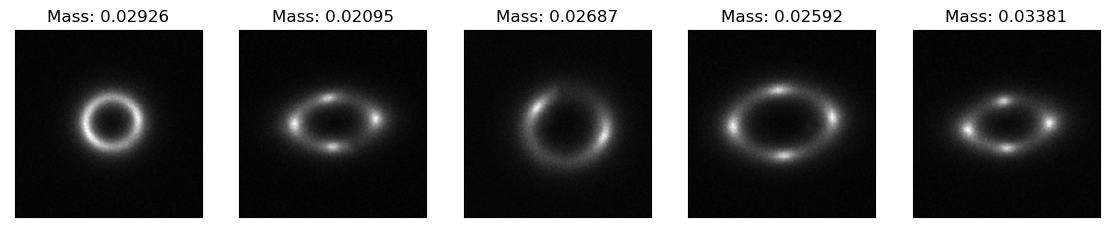

In [4]:
# Define the input paths
train_path = './'
train_files = [os.path.join(train_path, f) for f in os.listdir(train_path) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plot the samples 
i = 1
print('Samples: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files[:n]:
    ax = plt.subplot(1,n,i)
    data = np.load(image, allow_pickle=True)
    img = data[0].reshape(150,150)
    mass = data[1]
    plt.imshow(img, cmap='gray')
    ax.title.set_text(f'Mass: {mass:.5f}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()


#### 1.4 Data preparation

In [5]:
image_paths = glob.glob('*')
random.shuffle(image_paths)

size = len(image_paths)
train_size = 0.8
val_size = 0.1
test_size = 0.1

train_paths = image_paths[:int(size*train_size)]
val_paths = image_paths[int(size*train_size):int(size*(train_size+val_size))]
test_paths = image_paths[int(size*(train_size+val_size)):int(size*(train_size+val_size+test_size))]


In [6]:
class MyDataset(Dataset):
    def __init__(self, np_file_paths, transform=None):
        self.files = np_file_paths
        self.transform = transform
    
    def __getitem__(self, index):
        record = np.load(self.files[index],allow_pickle=True)
        image = record[0]
        image = torch.from_numpy(image).float()
        label = record[1]
        label = label.astype("float32")
        
        image = image.reshape((1, image.shape[0], image.shape[1]))
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.files)

In [7]:
# Define the trasformations to apply on images

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2))
])

valid_transform = transforms.Compose([
    transforms.Resize((150, 150))
])

test_tranform = transforms.Compose([
    transforms.Resize((150, 150))
])

# Create instances of train, validation and test datasets

train_dataset = MyDataset(train_paths, train_transform)
valid_dataset = MyDataset(val_paths, valid_transform)
test_dataset = MyDataset(test_paths, test_tranform)

batch_size = 64

# Create data loaders with a batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Training

#### 2.1 Defining Resnet-18 Model

In [9]:
class Resnet18(nn.Module):

    def __init__(self, pre_trained):
        super(Resnet18, self).__init__()
        self.backbone = models.resnet18(pretrained=pre_trained)
        self.backbone.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.backbone(x)

#### 2.2 Preparing to train the Resnet-18 Model

In [10]:
# Define a utility function to check the results of model on a given loader

def check_accuracy(loader, model, criterion, device):
    model.eval()
    loss_per_step = []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (x, y) in loader:
            x = x.to(device)
            y = y.to(device)

            score = model.forward(x)
            loss = criterion(score.ravel(), y)
            loss_per_step.append(loss.item())
            y_pred.extend(list(score.cpu().numpy()))
            y_true.extend(list(y.cpu().numpy()))
    model.train()

    r2 = r2_score(y_true, y_pred)
    return sum(loss_per_step) / len(loss_per_step), r2

In [11]:
# Create a directory to checkpoint the model
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")

In [12]:
# Define the hyperparameters and model
num_epochs = 100
lr = 1e-4
model = Resnet18(pre_trained=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# # Uncomment to resume training a model
# checkpoint = torch.load("")
# model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.8,
    patience=4,
    verbose=True,
    min_lr=1e-10
)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
# Start a new wandb run

wandb.init(
    project="deeplense-regression-test",
    config={
        "batch_size": batch_size,
        "learning_rate": lr,
        "architecture": "Resnet18",
        "epochs": num_epochs
    }
)

wandb.watch(model, log_freq=100)

wandb: Currently logged in as: yogesh174. Use `wandb login --relogin` to force relogin


[]

#### 2.3 Training/Fine-tuning the Resnet-18 Model

In [14]:
min_loss = 0

for epoch in range(num_epochs):
    losses_per_batch = []
    start_time = time.time()
    
    # Mini batch training
    p_bar = tqdm(enumerate(train_loader), leave=False, total=len(train_loader), file=sys.stdout)
    for batch_idx, (x_batch, y_batch) in p_bar:
        # Move data to gpu if available
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward prop
        scores = model.forward(x_batch)
        loss = criterion(scores.ravel(), y_batch)
        losses_per_batch.append(loss.item())

        # Backward prop
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent step
        optimizer.step()

    # Compute mse and loss
    val_loss, r2 = check_accuracy(valid_loader, model, criterion, device)
    train_loss = sum(losses_per_batch) / len(losses_per_batch)

    # lr scheduler
    scheduler.step(val_loss)

    # Save best model
    if (epoch == 0) or (val_loss < min_loss):
        check_point = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        print(f"epoch {epoch+1}: ", end="")

        checkpoint_file = "./checkpoint/best_model.pt"
        print("Saving model ...")
        torch.save(check_point, checkpoint_file)
        min_loss = val_loss

    end_time = time.time()
    
    # Print log
    print(f"epoch [{epoch + 1}/{num_epochs}], "
            f"train mse: {train_loss}, "
            f"val mse: {val_loss}, "
            f"val r2 score: {r2:.4f}, "
            f"time used: {(end_time - start_time)/60:.4f}m")
    
    # Send log
    wandb.log({'Train MSE': train_loss, 'Validation MSE': val_loss, 'Validation R2': r2, 'epoch': epoch, 'time': (end_time - start_time)/60})

epoch 1: Saving model ...                        
epoch [1/100], train mse: 0.014089054100797511, val mse: 0.00021078436338939355, val r2 score: -0.0047, time used: 1.0027m
epoch [2/100], train mse: 0.00022504669916816056, val mse: 0.00021103098697494715, val r2 score: -0.0029, time used: 0.8224m
epoch 3: Saving model ...                        
epoch [3/100], train mse: 0.00021959282635361887, val mse: 0.00020884117748209974, val r2 score: 0.0022, time used: 0.8134m
epoch 4: Saving model ...                        
epoch [4/100], train mse: 0.000214489389793016, val mse: 0.00020629024720619782, val r2 score: 0.0377, time used: 0.8208m
epoch [5/100], train mse: 0.00021097440694575197, val mse: 0.000206787811293907, val r2 score: 0.0213, time used: 0.8025m
epoch [6/100], train mse: 0.00020703631604555994, val mse: 0.00022421312041842612, val r2 score: -0.0711, time used: 0.8079m
epoch 7: Saving model ...                        
epoch [7/100], train mse: 0.0001994819748797454, val mse: 0

### 3. Testing

#### 3.1 Testing the Finetuned Resnet-18 Model on testing data

In [15]:
model = Resnet18(pre_trained=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

pretrained_model = "./checkpoint/best_model.pt"
checkpoint = torch.load(pretrained_model)
model.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### 3.2 Calculating MSE on test set

In [18]:
test_loss, r2 = check_accuracy(test_loader, model, criterion, device)
print(f"test mse loss: {test_loss}, r2: {r2}")

test mse loss: 6.066018761430314e-05, r2: 0.7171911919653813


### 4. Results

The given dataset is divided into 80% of training samples, 10% of validation samples and 10% of test samples.

Train MSE: 5.47e-05

Validation MSE: **5.93e-05** \
Validation R2 score: 0.718

Test MSE: **6.07e-05** \
Test R2 score: 0.717